# **TUGAS AKHIR**
Pada penelitian ini akan dilakukan pencarian model yang mampu mendeteksi 2 kelas diabetes retinopati (No DR dan Proliferative DR)

## Import Lib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import glob, os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Activation, Add
from keras.models import Model
from keras.activations import relu
from keras.backend import sigmoid
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time

## Percobaan 2 - VGG19

Link Dataset :
[Diabetes Retinopati](https://www.kaggle.com/competitions/diabetic-retinopathy-detection)

### Image Data Generator

VGG19 input requirement :
1. input shape 4D tensor (batch_size, height, width, channel)
2. input image size = 64,64,3

In [ ]:
train_path = 'C:/Dani/Kuliah/TA/data1/train'
valid_path = 'C:/Dani/Kuliah/TA/data1/val'
test_path = 'C:/Dani/Kuliah/TA/data1/test'

In [4]:
train_path = 'C:/Dani/Kuliah/TA/Git/data1/train'
valid_path = 'C:/Dani/Kuliah/TA/Git/data1/val'
test_path = 'C:/Dani/Kuliah/TA/Git/data1/test'

In [5]:
image_size = (224,224)
batch_size = 16
class1 = ['No DR', 'Proliferative DR']

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    preprocessing_function=None
)

# no dr - proliferative
print("\nNo DR - Proliferative DR")
print("Train : ")
train_generator_nodr_prodr = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    shuffle=True
)

print("Validation : ")
valid_generator_nodr_prodr = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    shuffle=True
)

print("Test : ")
test_generator_nodr_prodr = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    shuffle=True
)


No DR - Proliferative DR
Train : 
Found 15859 images belonging to 2 classes.
Validation : 
Found 5345 images belonging to 2 classes.
Test : 
Found 5314 images belonging to 2 classes.


### Development Phase : VGG16

In [6]:
input_shape = train_generator_nodr_prodr.image_shape

lr = 0.0001
steps_per_epoch = 50
epochs = 20
validation_steps = 30

In [7]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### MODEL

In [8]:
def VGG19 (input_shape) :

    x_input = Input(input_shape, name="input_layer") #VGG19 input_shape by default is (224,224,3)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    x = Dense(1, activation=sigmoid, name="predictions")(x) #3

    model = Model(inputs = x_input, outputs = x, name = "VGG19")

    return model

#### Compile & Train Model

In [9]:
model_VGG = VGG19(input_shape)
model_VGG.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [10]:
start = time.time()
history_VGG_nodr_prodr = model_VGG.fit(
      train_generator_nodr_prodr,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator_nodr_prodr,
      validation_steps = validation_steps,
      verbose=1)
end = time.time()
print("Time for learning: ", (end-start))

Epoch 1/20
50/50 [==============================] - 951s 19s/step - loss: 0.1478 - accuracy: 0.9837 - val_loss: 0.1510 - val_accuracy: 0.9771
Epoch 2/20
50/50 [==============================] - 851s 17s/step - loss: 0.1731 - accuracy: 0.9650 - val_loss: 0.1211 - val_accuracy: 0.9792
Epoch 3/20
50/50 [==============================] - 863s 17s/step - loss: 0.1239 - accuracy: 0.9750 - val_loss: 0.1057 - val_accuracy: 0.9812
Epoch 4/20
50/50 [==============================] - 859s 17s/step - loss: 0.1309 - accuracy: 0.9737 - val_loss: 0.1328 - val_accuracy: 0.9708
Epoch 5/20
50/50 [==============================] - 927s 19s/step - loss: 0.1143 - accuracy: 0.9775 - val_loss: 0.1133 - val_accuracy: 0.9771
Epoch 6/20
50/50 [==============================] - 1039s 21s/step - loss: 0.0948 - accuracy: 0.9812 - val_loss: 0.1127 - val_accuracy: 0.9771
Epoch 7/20
50/50 [==============================] - 987s 20s/step - loss: 0.1323 - accuracy: 0.9737 - val_loss: 0.1395 - val_accuracy: 0.9688
Epoch

KeyboardInterrupt: 

#### Save Model

In [ ]:
history_VGG_nodr_prodr.model.save("VGG19_nodr_prodr.h5")

C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate

In [ ]:
# loaded_vgg16 = load_model('VGG16.h5')

VGG19_loss, VGG19_accuracy = history_VGG_nodr_prodr.model.evaluate(train_generator_nodr_prodr, steps=50)
print("VGG19 train loss : ", VGG19_loss)
print("VGG19 train accuracy : ", VGG19_accuracy)

50/50 [==============================] - 193s 4s/step - loss: 0.1137 - accuracy: 0.9762
VGG19 train loss :  0.11370784044265747
VGG19 train accuracy :  0.9762499928474426


In [ ]:
VGG19_loss, VGG19_accuracy = history_VGG_nodr_prodr.model.evaluate(test_generator_nodr_prodr, steps=50)
print("VGG19 test loss : ", VGG19_loss)
print("VGG19 test accuracy : ", VGG19_accuracy)

50/50 [==============================] - 195s 4s/step - loss: 0.1518 - accuracy: 0.9650
VGG19 test loss :  0.15179169178009033
VGG19 test accuracy :  0.9649999737739563


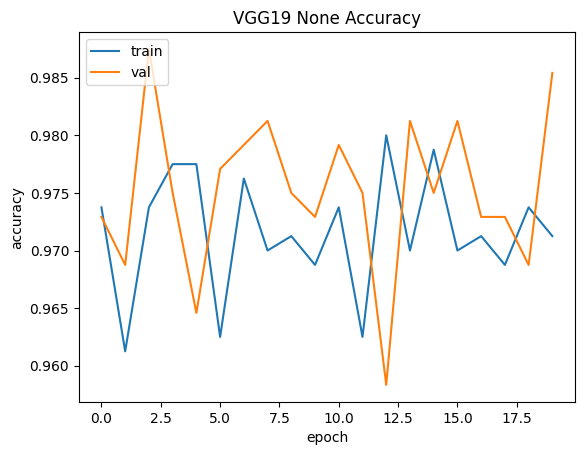

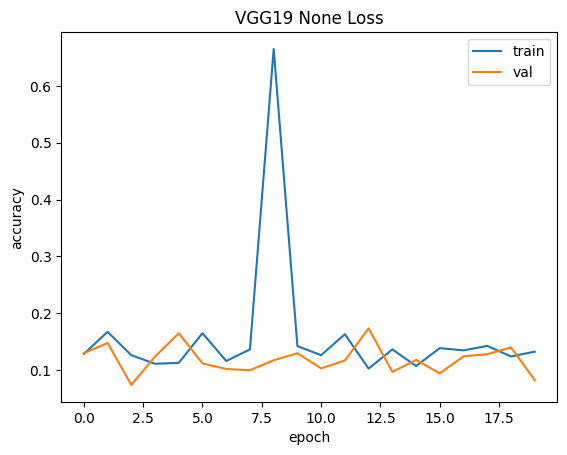

In [ ]:
show_accuracy(history_VGG_nodr_prodr, 'VGG19', 'None')
show_loss(history_VGG_nodr_prodr, 'VGG19', 'None')

#### Prediction

In [ ]:
y_pred = history_VGG_nodr_prodr.model.predict(test_generator_nodr_prodr)

333/333 [==============================] - 1308s 4s/step


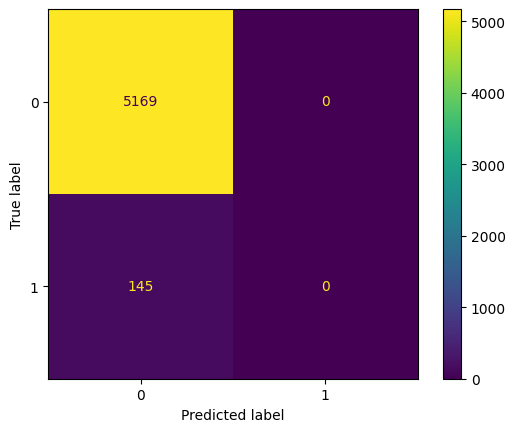

In [ ]:
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator_nodr_prodr.classes

cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

### Pemanggilan Model

In [37]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

image_size = (224, 224) # Bisa kalian ganti
labels = ['No DR', 'Proliferative DR']

In [38]:
MODEL_PATH = 'C:\Dani\Kuliah\TA\VGG19_nodr_prodr.h5'

model = load_model(MODEL_PATH, compile=False)

In [39]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    return nimg
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

#### Uji 1 DR - No: 113 DR: 0

In [4]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 463ms/step
No DR:  113
DR:  0


#### Uji 2 No - No: 118 DR: 0

In [5]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 840ms/step
No DR:  118
DR:  0


#### Uji 3 DR - No: 200 DR: 0

In [41]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 419ms/step
No DR:  200
DR:  0


#### Uji 4 DR - No: 200 DR: 0

In [42]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 388ms/step
No DR:  200
DR:  0


#### Uji 5 No - No: 200 DR: 0

In [43]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 353ms/step
No DR:  200
DR:  0


#### Uji 6 No - No: 200 DR: 0

In [44]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 360ms/step
No DR:  200
DR:  0


#### Uji 7 No - No: 200 DR: 0

In [10]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/test/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    print(label[35:-4], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 596ms/step
01d9477b1171_png.rf.106ae9ee6cefce0575b1234ae9e33e3e  -  No DR  -  0.025627818
1/1 [==============================] - 1s 616ms/step
01f7bb8be950_png.rf.f00e239651c17fdd19e79e43f923767c  -  No DR  -  0.026722364
1/1 [==============================] - 1s 561ms/step
0212dd31f623_png.rf.028a049dec0104cc7507e305b3350ef1  -  No DR  -  0.024149692
1/1 [==============================] - 1s 571ms/step
02358b47ea89_png.rf.f2c9e8e7f05075be774dfaebd5b84e20  -  No DR  -  0.025272463
1/1 [==============================] - 1s 593ms/step
04aef84a2cc1_png.rf.8277e09e3432478ed982f918812b8468  -  No DR  -  0.025924616
1/1 [==============================] - 1s 577ms/step
054b1b305160_png.rf.6fb82a9515a2cefbb1dc7d754f5efc79  -  No DR  -  0.023485811
1/1 [==============================] - 1s 541ms/step
060e00d1e2ab_png.rf.7d0ddd2e457230c6d7cc877ee35875f5  -  No DR  -  0.025064526
1/1 [==============================] - 1s 583ms/step
0773a1c326ad_png.rf.06a

## Percobaan 3 - VGG19 Cropted Dataset and Additional Prolifer

Dataset: terdapat penambahan data dari dataset Prolifer, sementara dataset No DR dicrop

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import glob, os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Activation, Add
from keras.models import Model
from keras.activations import relu
from keras.backend import sigmoid
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time

### Image Data Generator

In [3]:
train_path = 'D:/data3/data/train'
valid_path = 'D:/data3/data/val'
test_path = 'D:/data3/data/test'

In [ ]:
train_path = 'C:/Dani/Kuliah/TA/Git/data3/train'
valid_path = 'C:/Dani/Kuliah/TA/Git/data3/val'
test_path = 'C:/Dani/Kuliah/TA/Git/data3/test'

In [ ]:
image_size = (224,224)
batch_size = 16
class1 = ['No DR', 'Proliferative DR']

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    preprocessing_function=None
)

# no dr - proliferative
print("\nNo DR - Proliferative DR")
print("Train : ")
train_generator_nodr_prodr2 = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    shuffle=True
)

print("Validation : ")
valid_generator_nodr_prodr2 = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    shuffle=True
)

print("Test : ")
test_generator_nodr_prodr2 = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    shuffle=True
)


No DR - Proliferative DR
Train : 


Found 13191 images belonging to 2 classes.
Validation : 
Found 1232 images belonging to 2 classes.
Test : 
Found 6004 images belonging to 2 classes.


### Development Phase : VGG16 - Baru Tanpa Gray Scale

In [ ]:
input_shape = train_generator_nodr_prodr2.image_shape

lr = 0.0001
steps_per_epoch = 40
epochs = 10
validation_steps = 30

In [ ]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### MODEL

In [ ]:
def VGG19 (input_shape) :

    x_input = Input(input_shape, name="input_layer") #VGG19 input_shape by default is (64,64,1)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    x = Dense(1, activation=sigmoid, name="predictions")(x) #3

    model = Model(inputs = x_input, outputs = x, name = "VGG19")

    return model

#### Compile & Train Model

In [ ]:
model_VGG2 = VGG19(input_shape)
model_VGG2.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [ ]:
start = time.time()

history_VGG_nodr_prodr2 = model_VGG2.fit(
      train_generator_nodr_prodr2,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator_nodr_prodr2,
      validation_steps = validation_steps,
      verbose=1)

end = time.time()
print("Time for learning: ", (end-start))

Epoch 1/10
40/40 [==============================] - 851s 21s/step - loss: 0.7005 - accuracy: 0.5375 - val_loss: 0.7132 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 856s 21s/step - loss: 0.6944 - accuracy: 0.5266 - val_loss: 0.6890 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 815s 20s/step - loss: 0.6926 - accuracy: 0.5219 - val_loss: 0.7169 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 817s 20s/step - loss: 0.6940 - accuracy: 0.5344 - val_loss: 0.7260 - val_accuracy: 0.0000e+00
Epoch 5/10
40/40 [==============================] - 812s 20s/step - loss: 0.6939 - accuracy: 0.4984 - val_loss: 0.7175 - val_accuracy: 0.0000e+00
Epoch 6/10
40/40 [==============================] - 811s 20s/step - loss: 0.6918 - accuracy: 0.5391 - val_loss: 0.7256 - val_accuracy: 0.0000e+00
Epoch 7/10
40/40 [==============================] - 813s 20s/step - loss: 0.6930 - accuracy: 0.5109 - val_loss: 0.7319 - val_acc

#### Save Model

In [11]:
history_VGG_nodr_prodr2.model.save("VGG19_nodr_prodr_nogray.h5")

C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate

In [ ]:
# loaded_vgg16 = load_model('VGG16.h5')

VGG19_loss, VGG19_accuracy = history_VGG_nodr_prodr2.model.evaluate(train_generator_nodr_prodr2, steps=30)
print("VGG19 train loss : ", VGG19_loss)
print("VGG19 train accuracy : ", VGG19_accuracy)

30/30 [==============================] - 199s 7s/step - loss: 0.6931 - accuracy: 0.5125
VGG19 train loss :  0.6930720210075378
VGG19 train accuracy :  0.512499988079071


In [ ]:
VGG19_loss, VGG19_accuracy = history_VGG_nodr_prodr2.model.evaluate(test_generator_nodr_prodr2, steps=30)
print("VGG19 test loss : ", VGG19_loss)
print("VGG19 test accuracy : ", VGG19_accuracy)

30/30 [==============================] - 204s 7s/step - loss: 0.6816 - accuracy: 0.6354
VGG19 test loss :  0.6815565824508667
VGG19 test accuracy :  0.6354166865348816


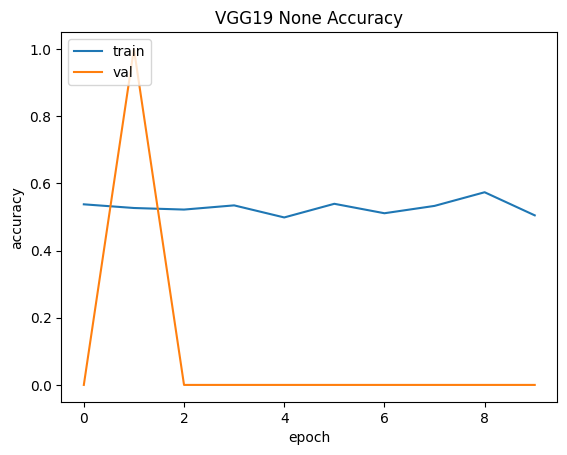

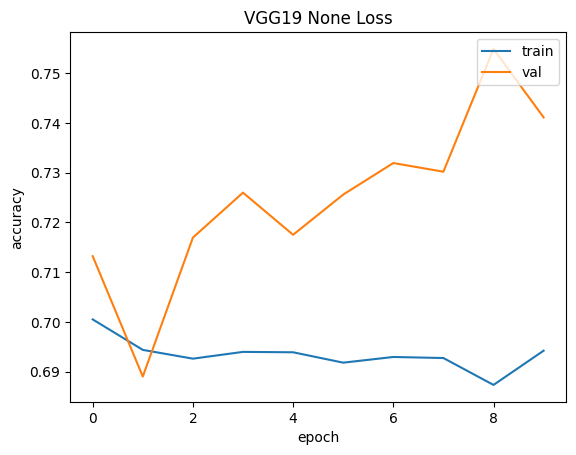

In [ ]:
show_accuracy(history_VGG_nodr_prodr2, 'VGG19', 'None')
show_loss(history_VGG_nodr_prodr2, 'VGG19', 'None')

#### Prediction

In [ ]:
y_pred = history_VGG_nodr_prodr2.model.predict(test_generator_nodr_prodr2)

376/376 [==============================] - 2500s 7s/step


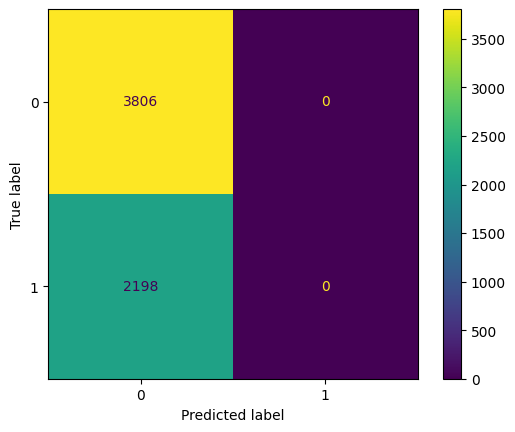

In [ ]:
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator_nodr_prodr2.classes

cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

### Panggil Model

In [11]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

image_size = (224, 224) # Bisa kalian ganti#define input shape
labels = ['No DR', 'Proliferative DR']

In [12]:
MODEL_PATH = 'C:\Dani\Kuliah\TA\VGG19_nodr_prodr_nogray.h5'

model = load_model(MODEL_PATH, compile=False)

In [13]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    return nimg
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

#### Uji 1 DR - No: 113 DR: 0

In [14]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 425ms/step
No DR:  113
DR:  0


#### Uji 2 No - No: 118 DR: 0

In [15]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    #print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 330ms/step
No DR:  118
DR:  0


#### Uji 3 DR - No: 88 DR: 0

In [16]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 495ms/step
18819_left  -  No DR  -  0.47996682
1/1 [==============================] - 0s 390ms/step
19961_left  -  No DR  -  0.47641572
1/1 [==============================] - 0s 406ms/step
20026_right  -  No DR  -  0.476479
1/1 [==============================] - 0s 398ms/step
20144_left  -  No DR  -  0.47761047
1/1 [==============================] - 0s 397ms/step
20146_right  -  No DR  -  0.47889933
1/1 [==============================] - 0s 400ms/step
21096_right  -  No DR  -  0.4766173
1/1 [==============================] - 0s 414ms/step
21511_right  -  No DR  -  0.47809154
1/1 [==============================] - 0s 400ms/step
21788_right  -  No DR  -  0.4765642
1/1 [==============================] - 0s 400ms/step
22160_right  -  No DR  -  0.47722617
1/1 [==============================] - 0s 400ms/step
22520_right  -  No DR  -  0.47822556
1/1 [==============================] - 0s 400ms/step
22669_left  -  No DR  -  0.4773095
1/1 [==============

#### Uji 4 DR - No: 157 DR: 0

In [17]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 445ms/step
10653_left  -  No DR  -  0.4769162
1/1 [==============================] - 1s 578ms/step
10785_left  -  No DR  -  0.47798377
1/1 [==============================] - 1s 717ms/step
1099_right  -  No DR  -  0.47820055
1/1 [==============================] - 0s 474ms/step
11417_right  -  No DR  -  0.4764586
1/1 [==============================] - 0s 472ms/step
11492_right  -  No DR  -  0.4783962
1/1 [==============================] - 1s 578ms/step
11854_right  -  No DR  -  0.47636074
1/1 [==============================] - 1s 565ms/step
12652_left  -  No DR  -  0.477384
1/1 [==============================] - 1s 691ms/step
12861_left  -  No DR  -  0.4764916
1/1 [==============================] - 1s 575ms/step
12995_left  -  No DR  -  0.47649893
1/1 [==============================] - 1s 591ms/step
13038_right  -  No DR  -  0.47641206
1/1 [==============================] - 0s 421ms/step
13387_right  -  No DR  -  0.47732928
1/1 [=================

#### Uji 5 No - No: 200 DR: 0

In [18]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 760ms/step
10009_right  -  No DR  -  0.47705254
1/1 [==============================] - 1s 670ms/step
10010_left  -  No DR  -  0.47865623
1/1 [==============================] - 1s 868ms/step
10015_right  -  No DR  -  0.4779029
1/1 [==============================] - 1s 879ms/step
10028_left  -  No DR  -  0.4764532
1/1 [==============================] - 1s 887ms/step
10028_right  -  No DR  -  0.4765434
1/1 [==============================] - 1s 894ms/step
10029_left  -  No DR  -  0.4800454
1/1 [==============================] - 1s 860ms/step
10031_right  -  No DR  -  0.4771255
1/1 [==============================] - 1s 881ms/step
10032_right  -  No DR  -  0.47732356
1/1 [==============================] - 1s 670ms/step
10042_right  -  No DR  -  0.4765534
1/1 [==============================] - 1s 607ms/step
10046_right  -  No DR  -  0.47702643
1/1 [==============================] - 1s 621ms/step
10048_left  -  No DR  -  0.47638032
1/1 [===============

#### Uji 6 No - No: 200 DR: 0

In [19]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 1s/step
10007_left  -  No DR  -  0.47813407
1/1 [==============================] - 1s 687ms/step
10009_left  -  No DR  -  0.47681576
1/1 [==============================] - 1s 672ms/step
10010_right  -  No DR  -  0.4789788
1/1 [==============================] - 1s 682ms/step
10022_left  -  No DR  -  0.4791977
1/1 [==============================] - 1s 705ms/step
10031_left  -  No DR  -  0.4773477
1/1 [==============================] - 1s 736ms/step
10035_right  -  No DR  -  0.4765185
1/1 [==============================] - 1s 723ms/step
10048_right  -  No DR  -  0.47637713
1/1 [==============================] - 1s 724ms/step
10050_left  -  No DR  -  0.47939572
1/1 [==============================] - 1s 699ms/step
10050_right  -  No DR  -  0.47986165
1/1 [==============================] - 1s 694ms/step
10059_left  -  No DR  -  0.47706035
1/1 [==============================] - 1s 816ms/step
10073_right  -  No DR  -  0.47643843
1/1 [==================

#### Uji 7 No - No: 200 DR: 0

In [20]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/test/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    print(label[35:-4], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 1s 837ms/step
01d9477b1171_png.rf.106ae9ee6cefce0575b1234ae9e33e3e  -  No DR  -  0.47677445
1/1 [==============================] - 1s 731ms/step
01f7bb8be950_png.rf.f00e239651c17fdd19e79e43f923767c  -  No DR  -  0.4763554
1/1 [==============================] - 1s 741ms/step
0212dd31f623_png.rf.028a049dec0104cc7507e305b3350ef1  -  No DR  -  0.47711027
1/1 [==============================] - 1s 732ms/step
02358b47ea89_png.rf.f2c9e8e7f05075be774dfaebd5b84e20  -  No DR  -  0.4764207
1/1 [==============================] - 1s 728ms/step
04aef84a2cc1_png.rf.8277e09e3432478ed982f918812b8468  -  No DR  -  0.4767219
1/1 [==============================] - 1s 730ms/step
054b1b305160_png.rf.6fb82a9515a2cefbb1dc7d754f5efc79  -  No DR  -  0.47775662
1/1 [==============================] - 1s 792ms/step
060e00d1e2ab_png.rf.7d0ddd2e457230c6d7cc877ee35875f5  -  No DR  -  0.47717384
1/1 [==============================] - 1s 798ms/step
0773a1c326ad_png.rf.06aeab157f536

## Percobaan 4 - ResNet50 No DR - PROLIFER

Link Dataset :
[Diabetes Retinopati](https://www.kaggle.com/competitions/diabetic-retinopathy-detection)

### Import Lib

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import glob, os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.activations import relu
from keras.backend import softmax, sigmoid
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import f_oneway
import time

### Image Data Generator

In [17]:
train_path = 'D:/data3/data/train'
valid_path = 'D:/data3/data/val'
test_path = 'D:/data3/data/test'

In [ ]:
train_path = 'C:/Dani/Kuliah/TA/Git/data3/train'
valid_path = 'C:/Dani/Kuliah/TA/Git/data3/val'
test_path = 'C:/Dani/Kuliah/TA/Git/data3/test'

In [18]:
image_size = (224,224)
batch_size = 16
class1 = ['No DR', 'Proliferative DR']

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    preprocessing_function=None
)

# no dr - proliferative
print("\nNo DR - Proliferative DR")
print("Train : ")
train_generator_nodr_prodr = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    
    shuffle=True
)

print("Validation : ")
valid_generator_nodr_prodr = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    
    shuffle=True
)

print("Test : ")
test_generator_nodr_prodr = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class1,
    
    shuffle=True
)


No DR - Proliferative DR
Train : 
Found 12893 images belonging to 2 classes.
Validation : 
Found 1530 images belonging to 2 classes.
Test : 
Found 6004 images belonging to 2 classes.


### Development Model

In [11]:
input_shape = train_generator_nodr_prodr.image_shape

lr = 0.0001
steps_per_epoch = 40
epochs = 10
validation_steps = 30

In [12]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### MODEL

In [13]:
def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[64, 64, 1]
def ResNet50(input_shape):
    # to make sure the len of the input shape is 3
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=1, activation=sigmoid)(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

#### Compile and Train Model

In [19]:
model_ResNet50 = ResNet50(input_shape)
model_ResNet50.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [20]:
start = time.time()
history_ResNet50 = model_ResNet50.fit(
      train_generator_nodr_prodr,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator_nodr_prodr,
      validation_steps = validation_steps,
      verbose=1)
end = time.time()
print("Time for learning: ", (end-start))

Epoch 1/10
40/40 [==============================] - 869s 21s/step - loss: 0.7616 - accuracy: 0.5938 - val_loss: 0.5777 - val_accuracy: 0.8188
Epoch 2/10
40/40 [==============================] - 702s 18s/step - loss: 0.6905 - accuracy: 0.6219 - val_loss: 0.5512 - val_accuracy: 0.8000
Epoch 3/10
40/40 [==============================] - 708s 18s/step - loss: 0.6853 - accuracy: 0.6641 - val_loss: 0.4897 - val_accuracy: 0.8125
Epoch 4/10
40/40 [==============================] - 541s 14s/step - loss: 0.5897 - accuracy: 0.6891 - val_loss: 0.5204 - val_accuracy: 0.7896
Epoch 5/10
40/40 [==============================] - 536s 13s/step - loss: 0.4724 - accuracy: 0.7781 - val_loss: 0.9899 - val_accuracy: 0.2000
Epoch 6/10
40/40 [==============================] - 506s 13s/step - loss: 0.4855 - accuracy: 0.7641 - val_loss: 1.0169 - val_accuracy: 0.1875
Epoch 7/10
40/40 [==============================] - 508s 13s/step - loss: 0.3872 - accuracy: 0.8328 - val_loss: 1.5251 - val_accuracy: 0.1979
Epoch 

#### Save Model

In [21]:
history_ResNet50.model.save("ResNet50_nodr_pro.h5")

C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate

In [22]:
# loaded_rn50 = load_model('ResNet50.h5')

ResNet50_loss, ResNet50_accuracy = history_ResNet50.model.evaluate(train_generator_nodr_prodr, steps=40)
print("ResNet50 train loss : ", ResNet50_loss)
print("ResNet50 train accuracy : ", ResNet50_accuracy)

40/40 [==============================] - 216s 5s/step - loss: 1.3664 - accuracy: 0.4875
ResNet50 train loss :  1.3663792610168457
ResNet50 train accuracy :  0.48750001192092896


In [ ]:
ResNet50_loss, ResNet50_accuracy = history_ResNet50.model.evaluate(test_generator_nodr_prodr, steps=40)
print("ResNet50 test loss : ", ResNet50_loss)
print("ResNet50 test accuracy : ", ResNet50_accuracy)

40/40 [==============================] - 87s 2s/step - loss: 0.4389 - accuracy: 0.8016
ResNet50 test loss :  0.43885523080825806
ResNet50 test accuracy :  0.801562488079071


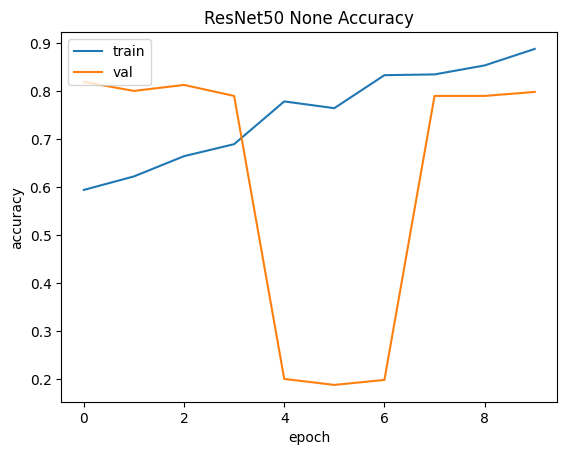

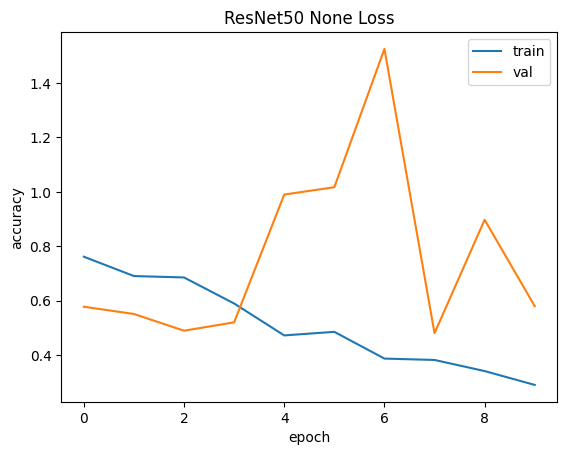

In [23]:
show_accuracy(history_ResNet50, 'ResNet50', 'None')
show_loss(history_ResNet50, 'ResNet50', 'None')

#### Prediction

In [24]:
y_pred = history_ResNet50.model.predict(test_generator_nodr_prodr)

376/376 [==============================] - 1982s 5s/step


In [25]:
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator_nodr_prodr.classes

cr = classification_report(y_true, y_pred_class)
print(cr)

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      3806
           1       0.00      0.00      0.00      2198

    accuracy                           0.63      6004
   macro avg       0.32      0.50      0.39      6004
weighted avg       0.40      0.63      0.49      6004



C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

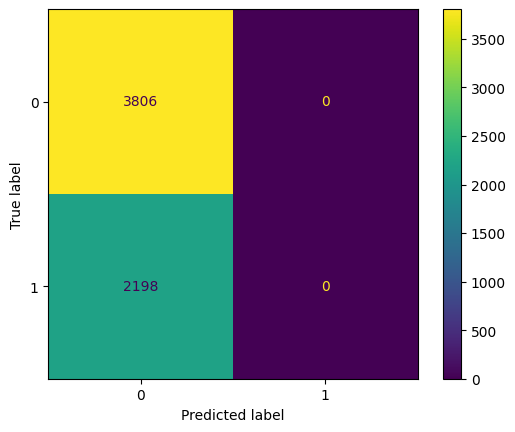

In [26]:
cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

### Pemanggilan Model

In [27]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

image_size = (224, 224) # Bisa kalian ganti
labels = ['No DR', 'Proliferative DR']

In [28]:
MODEL_PATH = 'C:\Dani\Kuliah\TA\ResNet50_nodr_pro.h5'

history_ResNet50 = load_model(MODEL_PATH, compile=False)

In [29]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    return nimg
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

#### Uji 1 DR - No: 113 DR: 0

In [30]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 160ms/step
No DR:  113
DR:  0


#### Uji 2 No - No: 118 DR: 0

In [31]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/valid/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 147ms/step
No DR:  118
DR:  0


#### Uji 3 DR - No: 200 DR: 0

In [32]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 159ms/step
No DR:  200
DR:  0


#### Uji 4 DR - No: 200 DR: 0

In [33]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 200ms/step
No DR:  200
DR:  0


#### Uji 5 No - No: 200 DR: 0

In [34]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/val/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 155ms/step
No DR:  200
DR:  0


#### Uji 6 No - No: 200 DR: 0

In [35]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'D:/data3/data/test/No DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 160ms/step
No DR:  200
DR:  0


#### Uji 7 No - No: 200 DR: 0

In [36]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data6/test/No_DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    value = y[0][0]
    indx = int(value)
    
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 200:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 151ms/step
No DR:  200
DR:  0


## Inception NoDR - Tidak Dimasukkan

Link Dataset :
[Diabetes Retinopati](https://www.kaggle.com/competitions/diabetic-retinopathy-detection)

### Import Lib

In [23]:
# General Libs
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import tensorflow as tf
import cv2
import glob, os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.activations import relu
from keras.backend import softmax, sigmoid
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import f_oneway

### Image Data Generator

In [2]:
train_path = 'C:/Dani/Kuliah/TA/data3/train'
valid_path = 'C:/Dani/Kuliah/TA/data3/val'
test_path = 'C:/Dani/Kuliah/TA/data3/test'

In [ ]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.33) #rescale=1./255,

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")#, color_mode='grayscale')

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")#, color_mode='grayscale')
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

In [3]:
image_size = (150,150)
batch_size = 32
seed = random.randint(1, 1000)
num_classes = 2
learning_rate = 0.0001

class1 = ['No DR', 'Proliferative DR']

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    preprocessing_function=preprocess_input
)

# no dr - proliferative
print("\nNo DR - Proliferative DR")
print("Train : ")
train_generator_nodr_prodr = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    shuffle=True,
    seed=seed,
    class_mode='categorical', 
    batch_size=batch_size, 
    #class_mode='binary',
    classes=class1
    
)

print("Validation : ")
valid_generator_nodr_prodr = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    shuffle=True,
    seed=seed,
    class_mode='categorical', 
    batch_size=batch_size, 
    #class_mode='binary',
    classes=class1
    
)

print("Test : ")
test_generator_nodr_prodr = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    shuffle=True,
    seed=seed,
    class_mode='categorical', 
    batch_size=batch_size, 
    #class_mode='binary',
    classes=class1
    
)


No DR - Proliferative DR
Train : 
Found 7321 images belonging to 2 classes.
Validation : 
Found 4743 images belonging to 2 classes.
Test : 
Found 4964 images belonging to 2 classes.


### Development Model

In [4]:
input_shape = train_generator_nodr_prodr.image_shape

lr = 0.0001
steps_per_epoch = 40
epochs = 10
validation_steps = 30

In [19]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### MODEL

In [7]:
# Loading MobileNet without top layer
pre_trained_weights = 'C:/Dani/Kuliah/TA/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = InceptionV3(weights=pre_trained_weights, include_top=False, input_shape=(image_size[0], image_size[1], 3))

x = base_model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model_inception = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
#optimizer = Adam(lr=learning_rate)
optimizer = keras.optimizers.RMSprop(lr=0.0001)
model_inception.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator_nodr_prodr.classes), 
            train_generator_nodr_prodr.classes)
class_weights

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [ ]:
#Salvar o melhor modelo
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

#### Compile and Train Model

In [10]:
history_inception = model_inception.fit(
        train_generator_nodr_prodr,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        #callbacks = callbacks_list,
        validation_data = valid_generator_nodr_prodr,
        verbose = 1,
        validation_steps = validation_steps,
        #class_weight = class_weights
        )

Epoch 1/10
40/40 [==============================] - 203s 5s/step - loss: 0.2290 - accuracy: 0.9453 - val_loss: 0.1068 - val_accuracy: 0.9792
Epoch 2/10
40/40 [==============================] - 249s 6s/step - loss: 0.2136 - accuracy: 0.9453 - val_loss: 0.0869 - val_accuracy: 0.9823
Epoch 3/10
40/40 [==============================] - 285s 7s/step - loss: 0.2329 - accuracy: 0.9383 - val_loss: 0.1638 - val_accuracy: 0.9833
Epoch 4/10
40/40 [==============================] - 223s 6s/step - loss: 0.2254 - accuracy: 0.9375 - val_loss: 0.1176 - val_accuracy: 0.9792
Epoch 5/10
40/40 [==============================] - 336s 9s/step - loss: 0.2208 - accuracy: 0.9391 - val_loss: 0.1032 - val_accuracy: 0.9833
Epoch 6/10
40/40 [==============================] - 294s 7s/step - loss: 0.1830 - accuracy: 0.9508 - val_loss: 0.1059 - val_accuracy: 0.9781
Epoch 7/10
40/40 [==============================] - 206s 5s/step - loss: 0.1939 - accuracy: 0.9453 - val_loss: 0.1220 - val_accuracy: 0.9875
Epoch 8/10
40

#### Save Model

In [11]:
history_inception.model.save("InceptionV3_nodr_pro.h5")

C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate

In [16]:
inception_loss, inception_accuracy = history_inception.model.evaluate(train_generator_nodr_prodr, steps=40)
print("Inception train loss : ", inception_loss)
print("Inception train accuracy : ", inception_accuracy)

40/40 [==============================] - 108s 3s/step - loss: 0.2017 - accuracy: 0.9398
Inception train loss :  0.2017134428024292
Inception train accuracy :  0.9398437738418579


In [17]:
inception_loss, inception_accuracy = history_inception.model.evaluate(test_generator_nodr_prodr, steps=40)
print("Inception train loss : ", inception_loss)
print("Inception train accuracy : ", inception_accuracy)

40/40 [==============================] - 98s 2s/step - loss: 0.1187 - accuracy: 0.9750
Inception train loss :  0.11870487779378891
Inception train accuracy :  0.9750000238418579


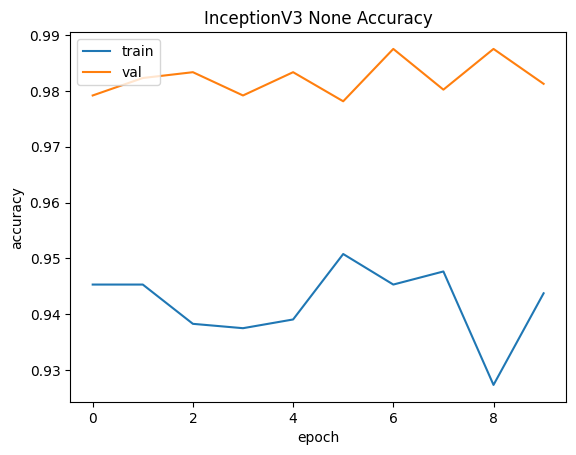

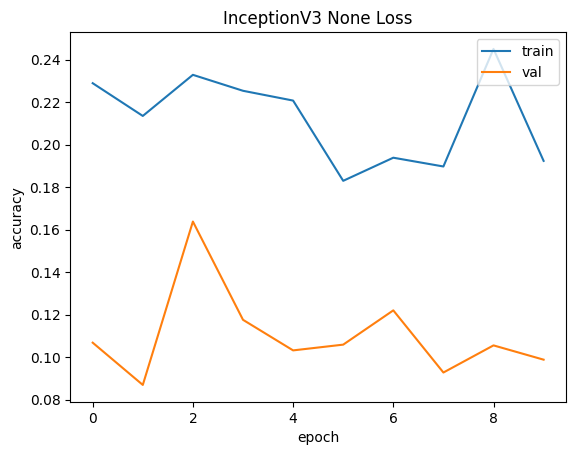

In [20]:
show_accuracy(history_inception, 'InceptionV3', 'None')
show_loss(history_inception, 'InceptionV3', 'None')

### Prediction

In [21]:
y_pred = history_inception.model.predict(test_generator_nodr_prodr)

156/156 [==============================] - 379s 2s/step


In [26]:
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator_nodr_prodr.classes

cr = classification_report(y_true, y_pred_class)
print(cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4807
           1       0.00      0.00      0.00       157

    accuracy                           0.97      4964
   macro avg       0.48      0.50      0.49      4964
weighted avg       0.94      0.97      0.95      4964



C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cintya Aprilia Dewi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

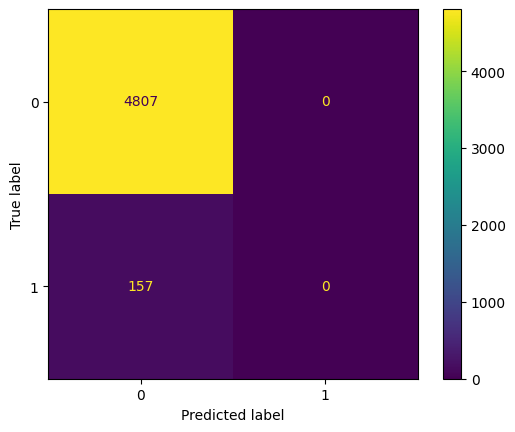

In [27]:
cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

### Pemanggilan Model

In [28]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

image_size = (150,150) # Bisa kalian ganti#define input shape
labels = ['No DR', 'Proliferative DR']

In [29]:
MODEL_PATH = 'C:\Dani\Kuliah\TA\InceptionV3_nodr_pro.h5'

model = load_model(MODEL_PATH, compile=False)

In [30]:
def preprocess(img,input_size):
    #nimg = img.convert('RGB').resize(input_size, resample= 0)
    #img_arr = (np.array(nimg))/255
    #return img_arr
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    #img_arr = (np.array(nimg))/255
    return nimg
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [33]:
import glob
No_DR = 0
P_DR = 0
count = 0

for label in glob.iglob(f'C:/Dani/Kuliah/TA/data1/val/Proliferative DR/*'):
    im = Image.open(label)
    #im = cv2.imread(label)
    X = preprocess(im,image_size)
    X = reshape([X])
    y = model.predict(X)
    
    print('y = ', y)
    value = y[0][0]
    indx = int(value)
    
    print(label[45:-5], ' - ', labels[indx], ' - ', value)
    if indx == 0:
        No_DR += 1
    elif indx == 1:
        P_DR +=1
    count+=1
    if count == 20:
        break
    
print('No DR: ', No_DR)
print('DR: ', P_DR)

1/1 [==============================] - 0s 84ms/step
y =  [[1. 0.]]
10017_left  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 79ms/step
y =  [[1. 0.]]
10653_right  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 69ms/step
y =  [[1. 0.]]
10904_left  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 83ms/step
y =  [[1. 0.]]
10954_right  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 87ms/step
y =  [[1. 0.]]
11032_left  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 88ms/step
y =  [[1. 0.]]
11032_right  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 85ms/step
y =  [[1. 0.]]
1138_left  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 79ms/step
y =  [[1. 0.]]
12419_left  -  Proliferative DR  -  1.0
1/1 [==============================] - 0s 76ms/step
y =  [[1. 0.]]
13308_right  -  Proliferative DR  -  1.0
1/1 [=============================